In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

###1.Model calls arriving at rate λ per hour (Poisson process) and service times of 1/μ hours (Exponential).


In [25]:
# Parameters
LAMBDA = 10   # arrival rate per hour
MU = 3        # service rate per hour

# Convert rates to per minute
arrival_rate = LAMBDA / 60
service_rate = MU / 60

# Generate inter-arrival times and service times
num_calls = 100
inter_arrival_times = np.random.exponential(1 / arrival_rate, num_calls)
service_times = np.random.exponential(1 / service_rate, num_calls)

print("Sample inter-arrival times (minutes):", inter_arrival_times[:5])
print("Sample service times (minutes):", service_times[:5])


Sample inter-arrival times (minutes): [ 2.63977764  3.53475086 19.17414663  5.62855298  1.43662154]
Sample service times (minutes): [67.19602179  3.29290507  6.97590609 29.18887278 10.54171125]


Here the call arrival rate is more than service rate and randomly generating inter-arrival and service time

###2.Simulate an M/M/s queue over an 8-hour shift, tracking each caller’s wait time and queue length.


In [16]:
def simulate_mm_s(s, sim_time_minutes=480):  # 8 hours = 480 minutes
    arrival_times = []
    service_start_times = []
    service_end_times = []
    queue_lengths = []
    next_available_time = np.zeros(s)  # servers

    time = 0
    while time < sim_time_minutes:
        inter_arrival = np.random.exponential(1 / arrival_rate)
        time += inter_arrival
        if time >= sim_time_minutes:
            break
        arrival_times.append(time)

        server_idx = np.argmin(next_available_time)
        start_time = max(time, next_available_time[server_idx])
        service_time = np.random.exponential(1 / service_rate)
        end_time = start_time + service_time

        next_available_time[server_idx] = end_time

        service_start_times.append(start_time)
        service_end_times.append(end_time)

        queue_length = np.sum(next_available_time > time)
        queue_lengths.append(queue_length)

    wait_times = np.array(service_start_times) - np.array(arrival_times)
    return {
        'wait_times': wait_times,
        'queue_lengths': np.array(queue_lengths),
        'arrival_times': np.array(arrival_times),
    }
simulate_mm_s(4)

{'wait_times': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         4.4575872 ,  3.68775283,  2.99901682,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  6.16451334,  8.43326825,
         7.69389188,  7.88602315,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  7.29780514,
        14.21470765,  0.        ,  0.        ,  0.28012767,  1.89602041,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         5.19179852,  5.18718605,  5.37163438,  0.        ,  0.        ,
         0.        ,  1.79371586,  0.        ,  4.23761151,  0.        ,
         0.        ,  3.97908503,  7.06812535,  4.00360689,  1.78459176,
         4.85660485,  4.17862276, 19.38379397, 13.73562772,  4.64942008,
         8.84392457,  5.60406676,  5.

Simulating an 8-hours shift for s servers and tracking wait times and queue lengths for each call



###3.Compare simulated averages to the M/M/1 analytic formula:
###                    Average customers in system L = ρ/(1−ρ)
###                    Average time in system W = L/λ


In [27]:
def analytic_mm1(lambda_per_hour, mu_per_hour):
    rho = lambda_per_hour / mu_per_hour
    L = rho / (1 - rho)
    W = L / lambda_per_hour
    return L, W

L, W = analytic_mm1(LAMBDA, MU)
print(f"M/M/1 Analytic → L = {abs(L):.2f}, W = {abs(W) * 60:.2f} minutes")  # Convert W to minutes


M/M/1 Analytic → L = 1.43, W = 8.57 minutes


Average callers L = 1.43 and Average time in system W = 8.57 minutes

###4.Test staffing levels s = 1…5 and choose the smallest s so that the 95th‐percentile wait ≤ 5 minutes. Also plot the distribution of wait times and queue lengths to mimic an operations‐dashboard.

In [22]:
staffing_results = {}

# Run simulations for s = 1 to 5 and store results
for s in range(1, 6):
    result = simulate_mm_s(s)
    wait_times = result['wait_times']
    perc_95 = np.percentile(wait_times, 95)
    staffing_results[s] = {
        'avg_wait': np.mean(wait_times),
        'perc_95_wait': perc_95,
        'avg_queue_len': np.mean(result['queue_lengths']),
        'wait_times': wait_times,
        'queue_lengths': result['queue_lengths'],
    }

# Print results for each staffing level from the single run
for s in staffing_results:
    print(f"s = {s}: 95th percentile wait = {staffing_results[s]['perc_95_wait']:.2f} min")

# Find minimal s where 95th percentile wait ≤ 5 min
try:
    # Use the results stored in staffing_results from the single loop run
    optimal_s = next(s for s in range(1, 6) if staffing_results[s]['perc_95_wait'] <= 5)
    print(f"\n✅ Minimum number of servers required = {optimal_s}")
except StopIteration:
    print("\nNo staffing level found where 95th percentile wait time is <= 5 min.")
    # Print the minimum 95th percentile wait found among the simulated scenarios
    min_perc_95 = min(staffing_results[s]['perc_95_wait'] for s in staffing_results)
    s_at_min_perc_95 = next(s for s in staffing_results if staffing_results[s]['perc_95_wait'] == min_perc_95)
    print(f"Minimum 95th percentile wait time achieved: {min_perc_95:.2f} min at s = {s_at_min_perc_95}")

s = 1: 95th percentile wait = 824.37 min
s = 2: 95th percentile wait = 254.83 min
s = 3: 95th percentile wait = 64.71 min
s = 4: 95th percentile wait = 7.20 min
s = 5: 95th percentile wait = 6.81 min

No staffing level found where 95th percentile wait time is <= 5 min.
Minimum 95th percentile wait time achieved: 6.81 min at s = 5


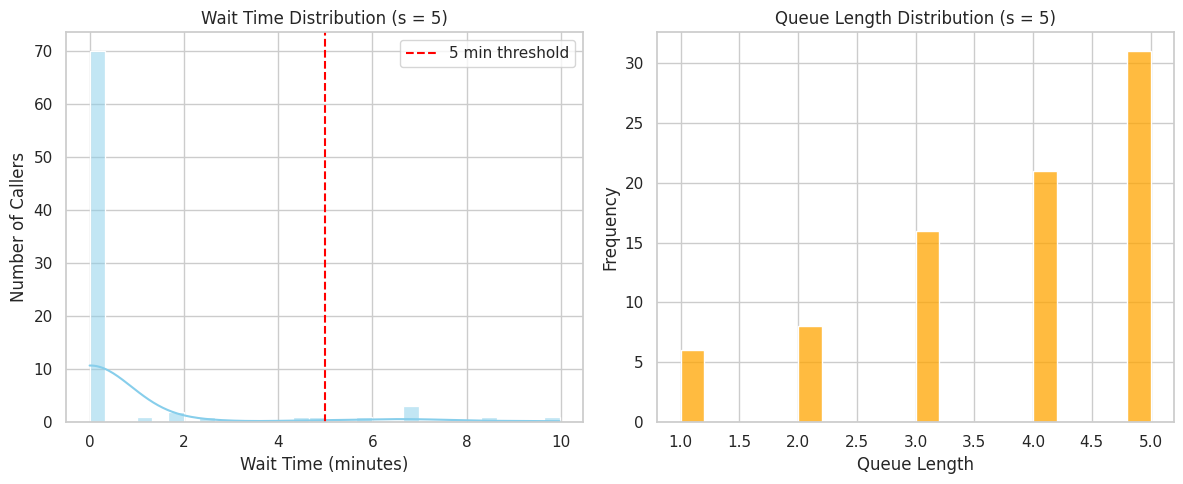

In [28]:
sns.set(style="whitegrid")
selected = optimal_s
data = staffing_results[selected]

plt.figure(figsize=(12, 5))

# Wait Time Distribution
plt.subplot(1, 2, 1)
sns.histplot(data['wait_times'], bins=30, kde=True, color='skyblue')
plt.axvline(5, color='red', linestyle='--', label='5 min threshold')
plt.title(f"Wait Time Distribution (s = {selected})")
plt.xlabel("Wait Time (minutes)")
plt.ylabel("Number of Callers")
plt.legend()

# Queue Length Distribution
plt.subplot(1, 2, 2)
sns.histplot(data['queue_lengths'], bins=20, kde=False, color='orange')
plt.title(f"Queue Length Distribution (s = {selected})")
plt.xlabel("Queue Length")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


The target was to find 95th percentile wait time ≤ 5 minutes but the result is not equvalent or less than 5 minutes in 5 servers so the minimum time taken by s = 5. 95th percentile wait ≈ 6.81 minutes